# To Design a CNN model to classify digits dataset(Built in 0_9) with pytorch framework. Show the some images from the dataset. Compute performance metrics and test the model through visualization of test results. Plot intermediate features and save the model. 

# Import Libraries and Set Up the Dataset

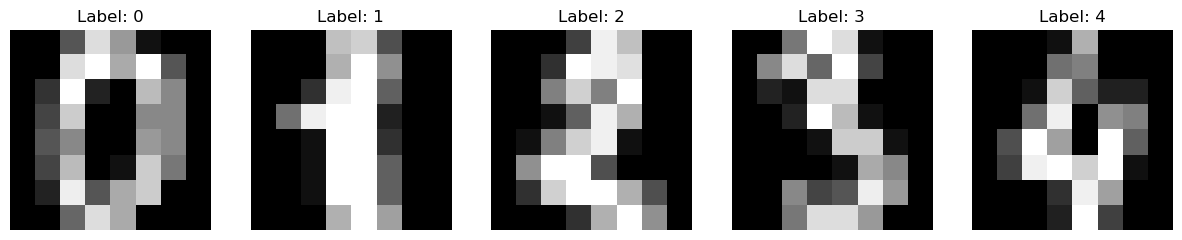

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split # For Training and Testing split
from sklearn.preprocessing import StandardScaler # For Normalization
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
digits = load_digits()

# Dataset attributes
X = digits.images  # Images (8x8 grayscale)
y = digits.target  # Labels (0-9)

# Visualize some images
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
for i, ax in enumerate(axes):
    ax.imshow(X[i], cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.show()

In [2]:
X.shape,X[0],y[4]

((1797, 8, 8),
 array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
        [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
        [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
        [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
        [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
        [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
        [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
        [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]]),
 4)

# Preprocess the Data

# Convert the dataset to a PyTorch-compatible format and scale the input data.

In [3]:
# Scale data to range [0, 1] and expand dimensions for CNN
X = X / 16.0  # Normalize (max pixel value is 16) for real images /255(max(X))
X = np.expand_dims(X, axis=1)  # Add channel dimension (N, 1, 8, 8)

In [4]:
X.shape

(1797, 1, 8, 8)

# Split into train and test sets


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train.shape

(1437, 1, 8, 8)

# Convert to PyTorch tensors

In [7]:
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

In [8]:
X_train.shape,y_train.shape

(torch.Size([1437, 1, 8, 8]), torch.Size([1437]))

# Create DataLoader objects

In [9]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Build the CNN Model for classification

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # Output: 16x8x8
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # Output: 32x8x8
        self.pool = nn.MaxPool2d(2, 2)  # Output: 32x4x4
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN()

# Define Loss Function and Optimizer

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the Model

In [12]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

Epoch [1/10], Loss: 2.0953
Epoch [2/10], Loss: 0.9914
Epoch [3/10], Loss: 0.4655
Epoch [4/10], Loss: 0.3328
Epoch [5/10], Loss: 0.2841
Epoch [6/10], Loss: 0.2112
Epoch [7/10], Loss: 0.2050
Epoch [8/10], Loss: 0.1874
Epoch [9/10], Loss: 0.1500
Epoch [10/10], Loss: 0.1309


# Evaluate the Model

In [13]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.78%


# Test Model and Visualize Test Results

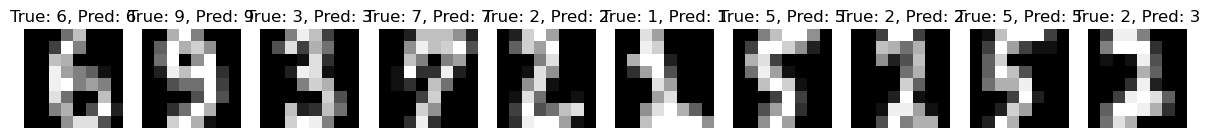

In [14]:
def visualize_test_results(model, test_loader):
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    fig, axes = plt.subplots(1, 10, figsize=(15, 4))
    for idx in range(10):
        axes[idx].imshow(images[idx].squeeze(), cmap='gray')
        axes[idx].set_title(f"True: {labels[idx].item()}, Pred: {predicted[idx].item()}")
        axes[idx].axis('off')
    plt.show()

visualize_test_results(model, test_loader)

# Compute Performance Metrics

In [15]:
from sklearn.metrics import classification_report, confusion_matrix

# Gather all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)]))

# Confusion matrix
conf_mat = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_mat)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.97      1.00      0.98        28
           2       1.00      0.97      0.98        33
           3       0.97      0.97      0.97        34
           4       0.94      1.00      0.97        46
           5       0.96      1.00      0.98        47
           6       1.00      0.97      0.99        35
           7       1.00      0.97      0.99        34
           8       1.00      0.90      0.95        30
           9       0.97      0.97      0.97        40

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360

Confusion Matrix:
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 32  1  0  0  0  0  0  0]
 [ 0  0  0 33  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 47  0  0  0  0]
 [

# Performance Metrics _ What they tell you about a model.

In [1]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
# Labels
y_true = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
y_pred = [1, 0, 1, 0, 0, 1, 0, 1, 1, 0]

In [4]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print(f"Confusion Matrix:")
print(f"[[TN={conf_matrix[0, 0]}  FP={conf_matrix[0, 1]}]")
print(f" [FN={conf_matrix[1, 0]}  TP={conf_matrix[1, 1]}]]")

Confusion Matrix:
[[TN=3  FP=1]
 [FN=2  TP=4]]


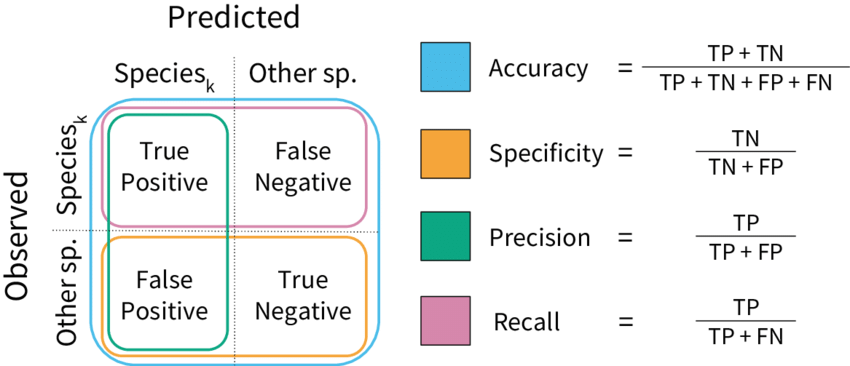

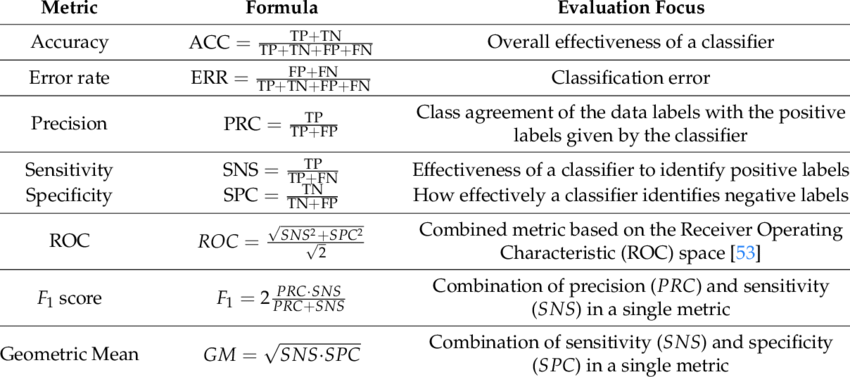

In [5]:
# Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

In [6]:
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Accuracy: 0.70
Precision: 0.80
Recall: 0.67
F1 Score: 0.73


# Visualize the Model Architecture and Compute Parameters

!pip install torchsummary

In [16]:
from torchsummary import summary

# Send the model to a device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Visualize the model and compute parameters
print("Model Summary:")
summary(model, input_size=(1, 8, 8))

Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 16, 8, 8]             160
              ReLU-2             [-1, 16, 8, 8]               0
            Conv2d-3             [-1, 32, 8, 8]           4,640
              ReLU-4             [-1, 32, 8, 8]               0
         MaxPool2d-5             [-1, 32, 4, 4]               0
            Linear-6                  [-1, 128]          65,664
              ReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 71,754
Trainable params: 71,754
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.27
Estimated Total Size (MB): 0.33
------------------------------

!pip install torchviz

In [17]:
from torchviz import make_dot

# Forward a random input through the model
sample_input = torch.randn(1, 1, 8, 8).to(device)  # Batch size = 1, channel = 1, image size = 8x8
output = model(sample_input)

# Generate and visualize the graph
graph = make_dot(output, params=dict(model.named_parameters()))
graph.render("cnn_model", format="png", cleanup=True)


'cnn_model.png'

# Saving the Model

In [18]:
# Save the model's state_dict (weights)
#torch.save(model.state_dict(), "digits_cnn_model.pth")

# Optionally, you can also save the entire model (including architecture):
torch.save(model, "digits_cnn_full_model.pth")

# Next time You can Directly Load the Model and use it in real time: Inferencing

In [19]:
# Load the model's state_dict
model = CNN()
model.load_state_dict(torch.load("digits_cnn_model.pth", weights_only=True))
#model.load_state_dict(torch.load("digits_cnn_model.pth"))
model.eval()  # Set the model to evaluation mode
# Load the model's state_dict with weights_only=True

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

# Visualize Intermediate Features After Each Layer

To visualize intermediate features, we can register hooks on the layers of the model. 
A hook allows us to access the output of each layer during the forward pass. 
We'll use forward hooks to extract and store these intermediate feature maps.

# Define Hook Function:

In [20]:
import matplotlib.pyplot as plt

# List to store the intermediate outputs
intermediate_outputs = []

# Hook function to save intermediate outputs
def hook_fn(module, input, output):
    intermediate_outputs.append(output)

# Register hooks for each convolutional and fully connected layer
hooks = []

# Register hook for conv1
hooks.append(model.conv1.register_forward_hook(hook_fn))

# Register hook for conv2
hooks.append(model.conv2.register_forward_hook(hook_fn))

# Register hook for fc1
hooks.append(model.fc1.register_forward_hook(hook_fn))

# Register hook for fc2
hooks.append(model.fc2.register_forward_hook(hook_fn))

# Pass Input Through the Model and Visualize Features: pass a sample image through the model and visualize the intermediate outputs.

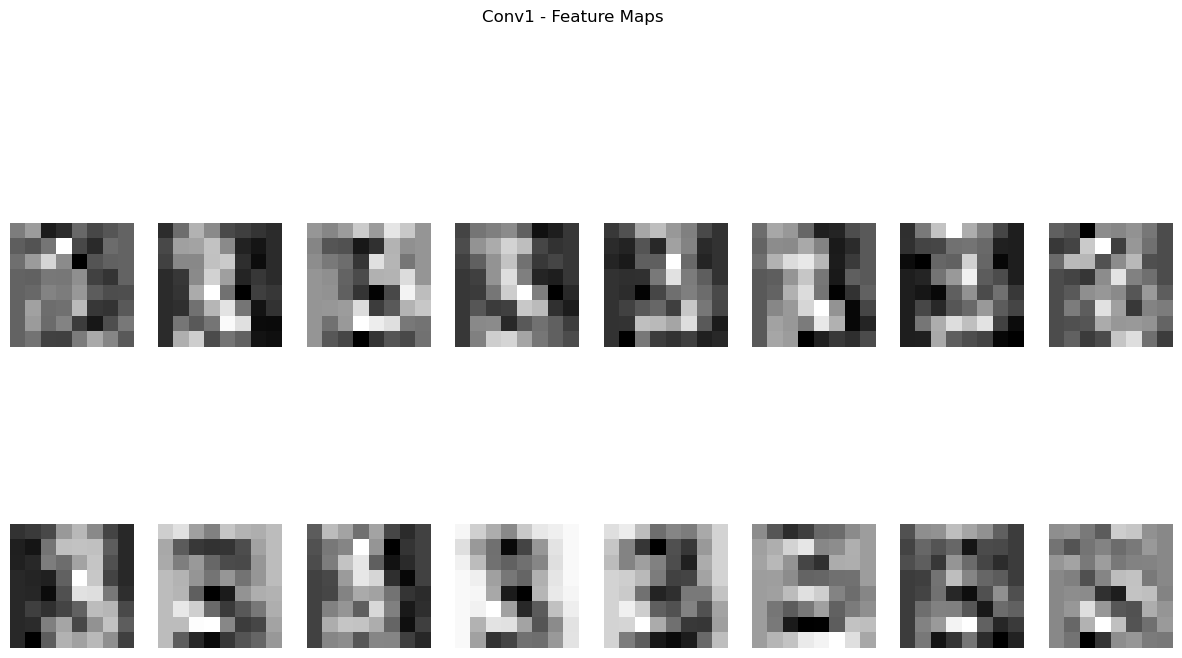

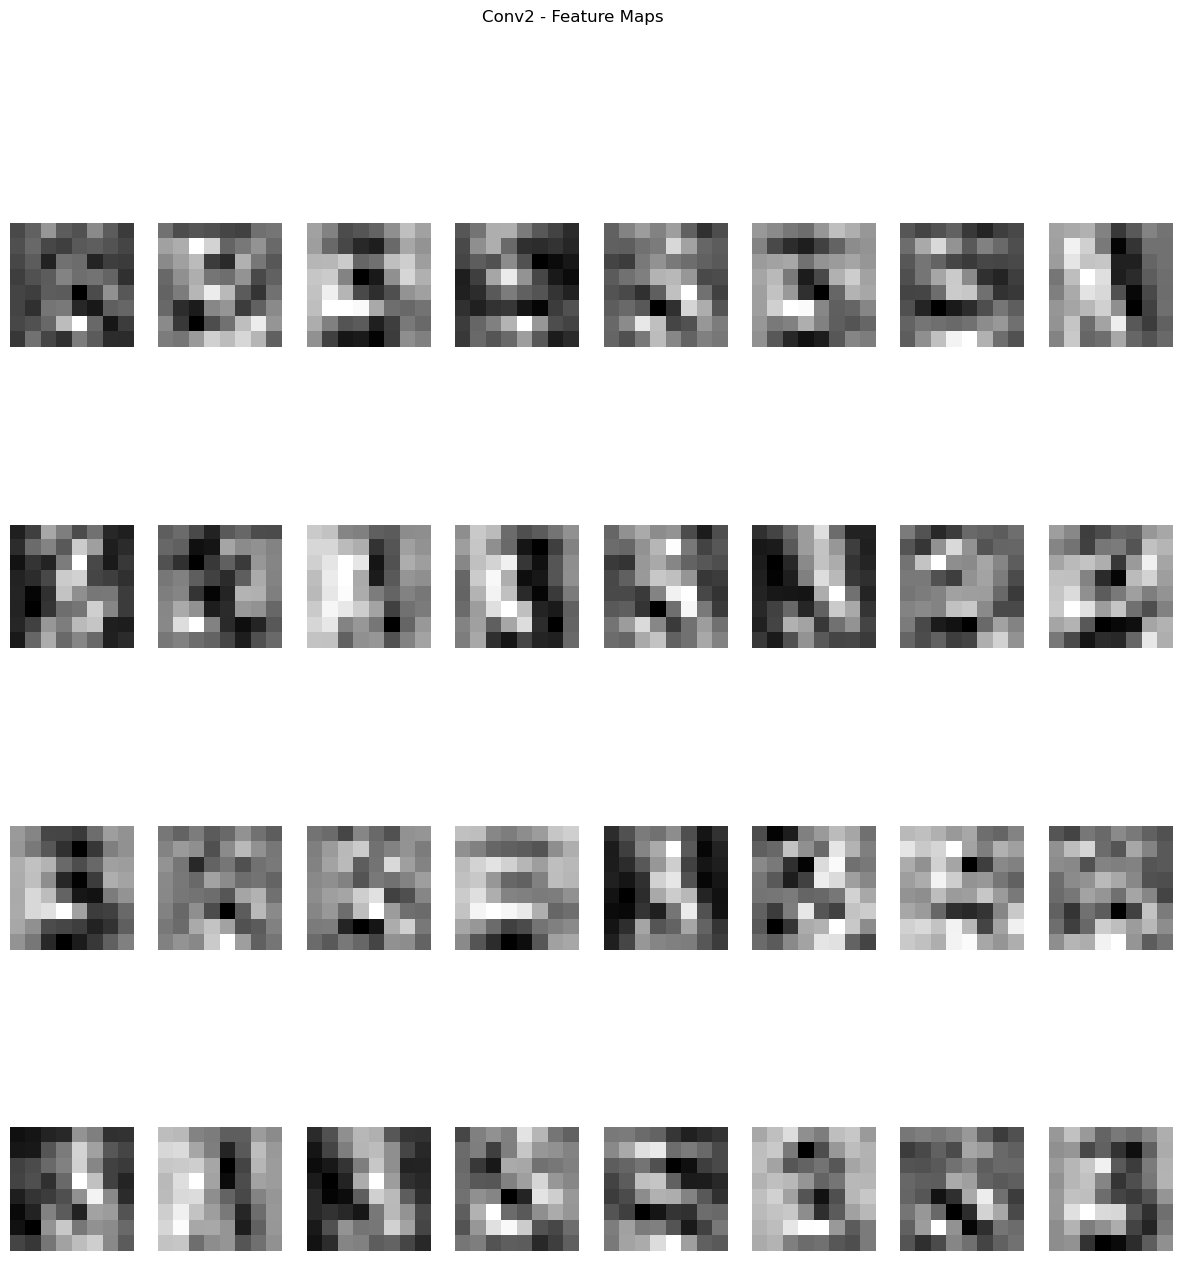

In [21]:
# Example input from the test set
sample_image, _ = test_dataset[2]  # Get the first image from the test dataset
sample_image = sample_image.unsqueeze(0).to(device)  # Add batch dimension and move to device

# Move the model to the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Move the input data to the same device
sample_image = sample_image.to(device)

## Now you can pass the input data through the model
#output = model(sample_image)

# Pass the sample image through the model
model(sample_image)

# Visualize the intermediate feature maps
def visualize_intermediate_features():
    layer_names = ['Conv1', 'Conv2', 'FC1', 'FC2']
    
    for i, layer_output in enumerate(intermediate_outputs):
        output = layer_output.squeeze(0).cpu().detach().numpy()  # Remove batch dimension and convert to numpy

        # For convolutional layers, output is 3D: (channels, height, width)
        if len(output.shape) == 3:
            num_features = output.shape[0]
            plt.figure(figsize=(15, 15))
            for j in range(num_features):
                plt.subplot(4, 8, j + 1)
                plt.imshow(output[j], cmap='gray')
                plt.axis('off')
            plt.suptitle(f"{layer_names[i]} - Feature Maps")
            plt.show()
        
        # For fully connected layers, output is 2D: (batch_size, num_features)
        elif len(output.shape) == 2:
            plt.figure(figsize=(10, 5))
            plt.imshow(output, cmap='viridis', aspect='auto')
            plt.title(f"{layer_names[i]} - FC Layer Output")
            plt.colorbar()
            plt.show()

# Visualize the intermediate feature maps after the forward pass
visualize_intermediate_features()

# Clean Up: Remove Hooks

In [22]:
# Remove the hooks
for hook in hooks:
    hook.remove()

# POST LAB: Design updated CNN Model with a convolutional layer and a Maxpooling layer report your results.